# Research hackathon year 1 - Fraudulent job advertisement detection

Data: http://emscad.samos.aegean.gr/

Aim: Engineering structured data to predict fraudulent job advertisement.

### Imports

In [33]:
import pandas as pd
import numpy as np

# For classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# For feature engineering
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk.tokenize as nt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaole/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/thaole/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# Load data
raw_data = pd.read_csv("emscad_v1.csv")
raw_data.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f


### Oversampling

In [35]:
def over_sampler(data):
    data = data.replace(np.nan, "", regex=True)
    
    #Make a balanced dataset by oversampling
    data_Fraud = data[data['fraudulent']=='t']
    data_NonFraud =  data[data['fraudulent']=='f']    
    df_fraud_example = pd.concat([data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                  data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                  data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                 data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                 data_Fraud, data_Fraud, data_Fraud, data_Fraud], axis = 0)
    data_balanced = pd.concat([data_NonFraud, df_fraud_example], axis = 0)
    data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)
    return data_balanced

In [36]:
raw_data = over_sampler(raw_data)

In [37]:
raw_data['description']

0        <p><b>Interviewing Now for Sales Rep Positions...
1        <p></p>\r\n<p><a href="#URL_fc53739b66f501f159...
2        <p>Fabrily is looking for an awesome Customer ...
3        <p>Advertising Sales Representative<br><br>Fut...
4        <p>Description</p>\r\n<p> </p>\r\n<p>Our beaut...
                               ...                        
34329    <p>A truly fantastic opportunity offering a st...
34330    <p><b>You will assist in building new business...
34331    <p><b>Space Ape is a “San Francisco Style” tec...
34332    <p>Job Description</p>\r\n<p>Administrative As...
34333    <p></p>\r\n<p><a href="#URL_fc53739b66f501f159...
Name: description, Length: 34334, dtype: object

## Data Cleaning

In [38]:
#Function to return wordcounts in strings
def clean_sequence(string):
    string = string.encode("ascii", "ignore").decode()
    string_words = word_tokenize(string)
    return len([word for word in string_words if word.lower() not in stop_words])

def clean_data(data):
    #Change all boolean variables to binary representations.
    data['fraudulent'] = np.where(data['fraudulent']=='t', 1, 0)
    data['telecommuting'] = np.where(data['telecommuting']=='t', 1, 0)
    data['has_company_logo'] = np.where(data['has_company_logo']=='t', 1, 0)
    data['has_questions'] = np.where(data['has_questions']=='t', 1, 0)
    
    #Get wordcounts
    data['description'] = data['description'].apply(lambda x: clean_sequence(str(x)))
    data['benefits'] = data['benefits'].apply(lambda x: clean_sequence(str(x)))
    data['requirements'] = data['requirements'].apply(lambda x: clean_sequence(str(x)))
    data['company_profile'] = data['company_profile'].apply(lambda x: clean_sequence(str(x)))
    return data


def change_to_ordinal(data):
    scale_mapper = {'Entry level':1, 'Not Applicable':0, 'Associate':3, 'Internship':2, 'Mid-Senior level':4, 'Director':5,'Executive':5}
    data['required_experience 1'] = data['required_experience'].replace(scale_mapper)
    data['required_experience 1'] = data['required_experience 1'].replace(np.nan, 0, regex=True)
    return data

list1 = ['..','!!','??']
spamwords_fraudulent = ['home', 'extra' 'easy money', 'week', 'online', 'no experience']

#Function to check whether a text has consecutive puntuation.
def consecutive_punct(list1, list2):
    if any( str in list1 for str in list2):
        return 1
    return 0

In [39]:
cleaned_data = clean_data(raw_data)
cleaned_data.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Sales Representative with Management Training ...,"US, TX, Corpus Christi",DTVCC,45000-67000,80,186,46,407,0,1,0,Full-time,Not Applicable,Unspecified,Consumer Services,Sales,0,f
1,UST Testing Technician II,"US, CA, Bakersfield",Oil & Energy,65000-75000,155,214,107,175,0,1,1,Full-time,Mid-Senior level,Certification,Oil & Energy,Other,1,f
2,CUSTOMER EXPERIENCE SUPERSTAR (Languages are a...,"GB, LND, London",,,81,138,174,49,0,1,0,Full-time,,,,,0,f


## Feature Engineering

In [40]:
# requiring low education
raw_data['low_required_education'] = 0
raw_data.loc[raw_data['required_education'] == ( 'High School or equivalent' or 'Unspecified' or 'Some High School Coursework' or '' or 'Vocational - HS Diploma' or 'Vocational - Degree' or 'Some College Coursework Completed'), ['low_required_education']] = 1

cleaned_data['low_required_education'] = raw_data['low_required_education']

In [41]:
cleaned_data['low_required_education'].value_counts()

0    29024
1     5310
Name: low_required_education, dtype: int64

In [44]:
# feature contains money_in_title, money_in_description
currencies= ['$','£','¥','€']

# create a function to check if a string contains any currency symbol
def contains_currency(s):
    return any(currency in s for currency in currencies)

# reload data
raw_data = pd.read_csv("emscad_v1.csv")
raw_data = over_sampler(raw_data)

# apply the function
cleaned_data['money_in_title'] = raw_data['title'].apply(contains_currency).astype(int)
cleaned_data['money_in_desc'] = raw_data['description'].apply(contains_currency).astype(int)

In [46]:
# check if text contains consecutive punctuations
punctuations = ['..','!!','??']

# create a function to check if a string contains consecutive punctuations
def contains_cons_punc(s):
    return any(punct in s for punct in punctuations)

# apply the function
cleaned_data['cons_punc_des'] = raw_data['description'].apply(contains_cons_punc).astype(int)
cleaned_data['cons_punc_title'] = raw_data['title'].apply(contains_cons_punc).astype(int)

In [47]:
# create some boolean variables
cleaned_data["has_short_company_profile"]= np.where(cleaned_data['company_profile'] < 10, 1, 0)
cleaned_data["has_short_requirements"]= np.where(cleaned_data['requirements'] < 10, 1, 0)

In [48]:
cleaned_data.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'in_balanced_dataset', 'low_required_education',
       'money_in_title', 'money_in_desc', 'cons_punc_des', 'cons_punc_title',
       'has_short_company_profile', 'has_short_requirements'],
      dtype='object')

In [50]:
final_data = cleaned_data[['fraudulent', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions',
       'money_in_title', 'money_in_desc', 'cons_punc_des',
       'cons_punc_title', 'low_required_education',
       'has_short_company_profile', 'has_short_requirements']]
final_data

,fraudulent,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,money_in_title,money_in_desc,cons_punc_des,cons_punc_title,low_required_education,has_short_company_profile,has_short_requirements
0,0,80,186,46,407,0,1,0,0,0,0,0,0,0,0
1,1,155,214,107,175,0,1,1,0,0,0,0,0,0,0
2,0,81,138,174,49,0,1,0,0,0,0,0,0,0,0
3,0,0,230,51,35,0,0,0,0,0,0,0,0,1,0
4,0,0,119,90,11,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34329,0,142,176,107,93,0,1,1,0,0,0,0,0,0,0
34330,0,54,151,148,0,0,1,1,0,0,0,0,0,0,0
34331,0,199,161,0,0,0,1,0,0,0,0,0,0,0,1
34332,1,0,202,0,0,0,0,0,0,0,0,0,0,1,1


## Feature selection

[0.17002326 0.18030866 0.13460932 0.13046929 0.0084734  0.12177639
 0.02807657 0.0013462  0.00169744 0.00121784 0.00066176 0.04014031
 0.17292771 0.00827184]


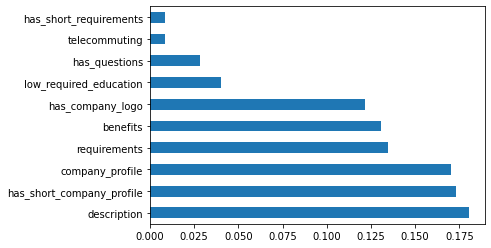

In [51]:
X = final_data.iloc[:,1:16] 
y = final_data.iloc[:,0]    
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Result shows that the 10 most important features are: description, has_short_company_profile, company_profile, requirements, benefits, has_company_logom low_required_education, has_questions, telecommuting, has_short_requirements.

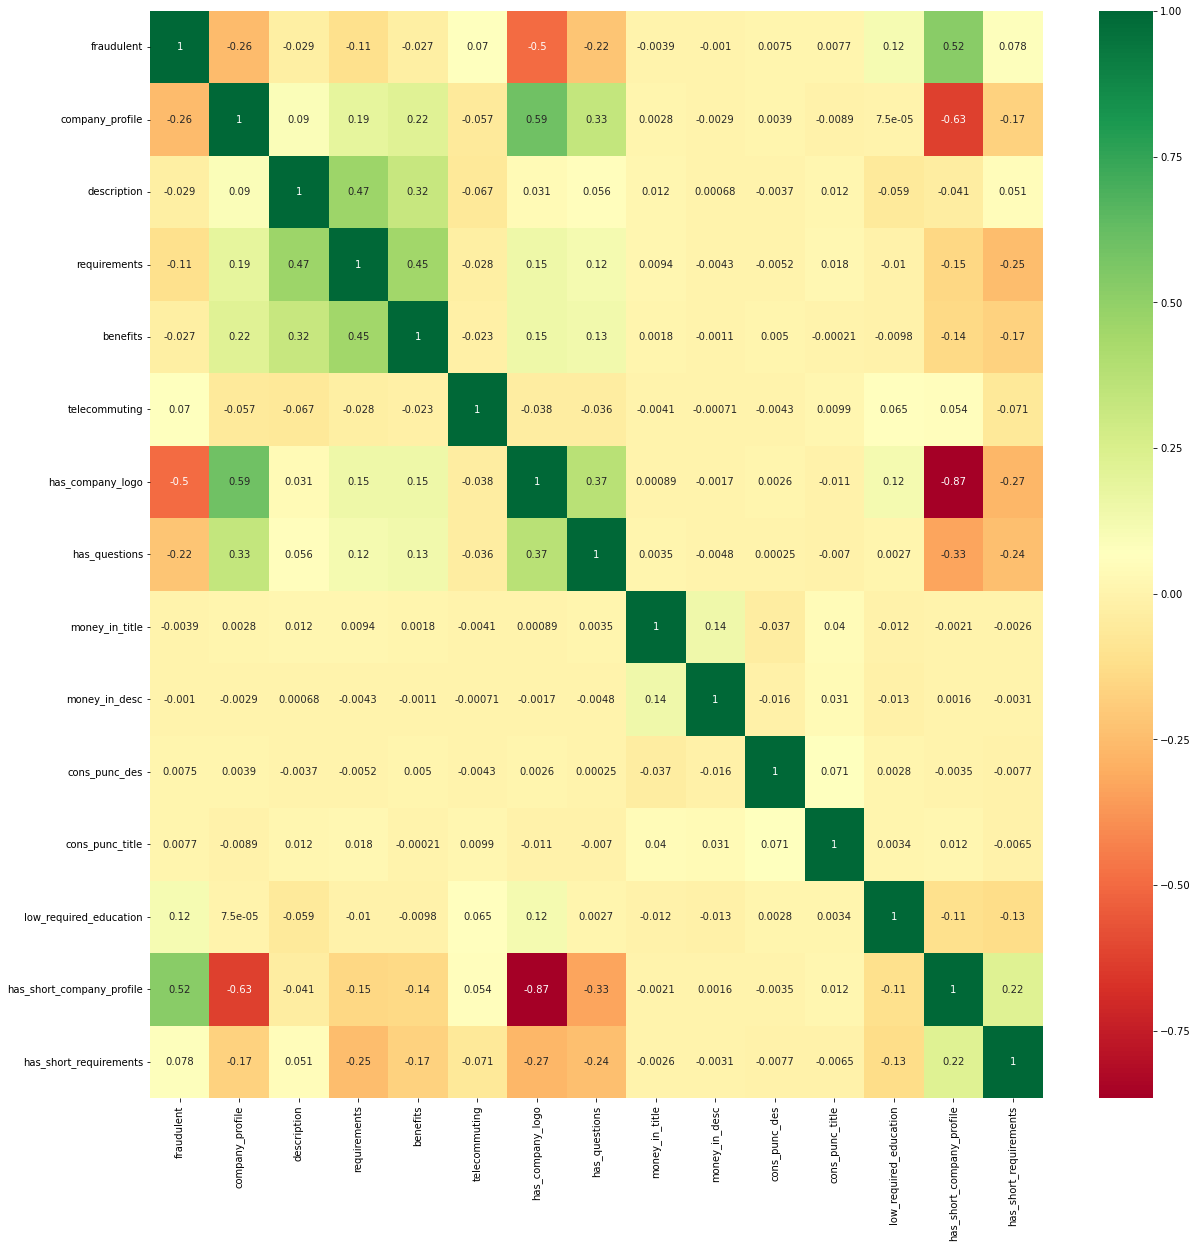

In [52]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = final_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(final_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Result shows that the most important features are: has_short_company_profile, has_company_logo, company_profile, has_short_description, low_require_education, requirements, benefits, has_short_requirements, telecommuting.

## ML models


In [ ]:
selected_data = final_data[[]]